# Nandini Jaiswal - MDS202335

# Assignment 5 - Transfer Learning for text data using Transformer


# Installing Required Python Packages

In [2]:
!pip install --quiet transformers torch pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00


# Importing Libraries and Downloading NLTK Resources


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, optimization
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import pandas as pd
from IPython.display import display, HTML
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading the dataset

### Detecting File Encoding with `chardet`

In [11]:
def detect_file_encoding(file_path, sample_size=10000):
    """
    Detect the encoding of a file using chardet library.

    Args:
        file_path (str): Path to the file to analyze
        sample_size (int): Number of bytes to use for detection (default: 10000)

    Returns:
        File 'encoding'
    """
    try:
        with open(file_path, 'rb') as f:
            raw_data = f.read(sample_size)
        result = chardet.detect(raw_data)
        return result['encoding']
    except FileNotFoundError:
        return {'error': 'File not found'}
    except Exception as e:
        return {'error': str(e)}

### Loading CSV Files with Detected Encoding

In [12]:
def load_csv_with_encoding(file_path):
    try:
        detected_encoding = detect_file_encoding(file_path)
        return pd.read_csv(file_path, encoding=detected_encoding)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [13]:
train_df = load_csv_with_encoding('/content/train.csv')
test_df = load_csv_with_encoding('/content/test.csv')

In [14]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (27481, 10)
Test data shape: (4815, 9)


### Check the stucture of the training set

In [15]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [16]:
print(train_df['sentiment'].value_counts())

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


### Check the structure of the test set

In [17]:
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [18]:
print(test_df['sentiment'].value_counts())

sentiment
neutral     1430
positive    1103
negative    1001
Name: count, dtype: int64


# Check for missing values

In [19]:
# Check for missing values
print("\nMissing values in training data:")
print(train_df[['text', 'sentiment']].isnull().sum())
print("\nMissing values in test data:")
print(test_df[['text', 'sentiment']].isnull().sum())

# Remove rows with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()


Missing values in training data:
text         1
sentiment    0
dtype: int64

Missing values in test data:
text         1281
sentiment    1281
dtype: int64


In [20]:
nan_counts = test_df.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

Number of NaN values in each column:
 textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


In [21]:
nan_counts = train_df.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

Number of NaN values in each column:
 textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


# Mapping Sentiment Labels to Numerical Values

In [22]:
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['label'] = train_df['sentiment'].map(sentiment_mapping)
test_df['label'] = test_df['sentiment'].map(sentiment_mapping)

In [23]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,0


### Split train into train and validation

In [24]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 24732
Validation size: 2748
Test size: 3534


# Exploratory Data Analysis

In [17]:
# Set style for plots
plt.style.use('ggplot')
sns.set_palette("husl")

### Sentiment Distribution Analysis

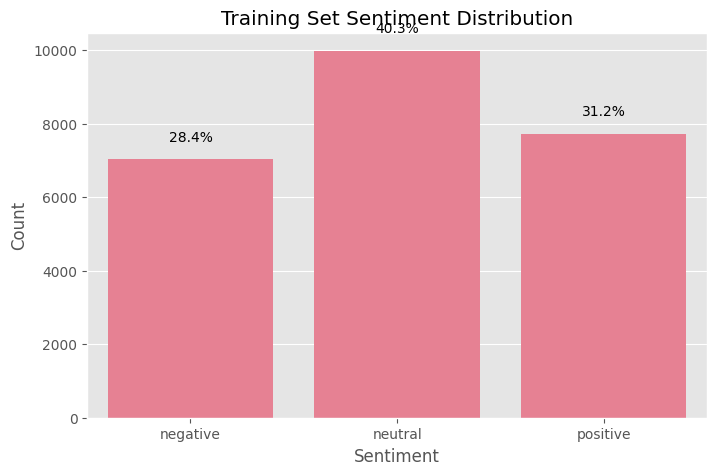

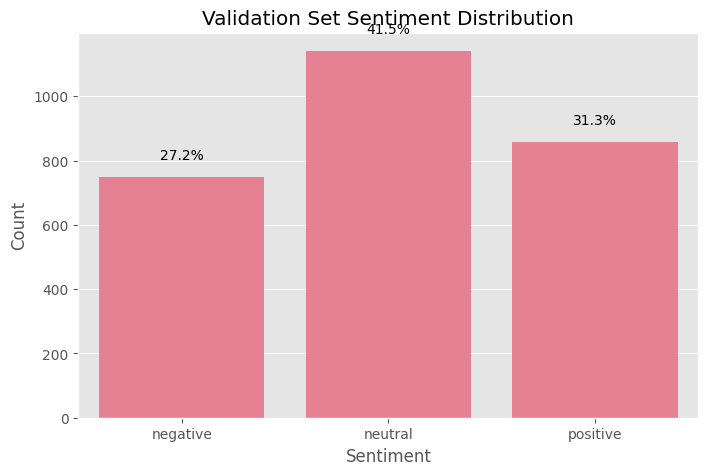

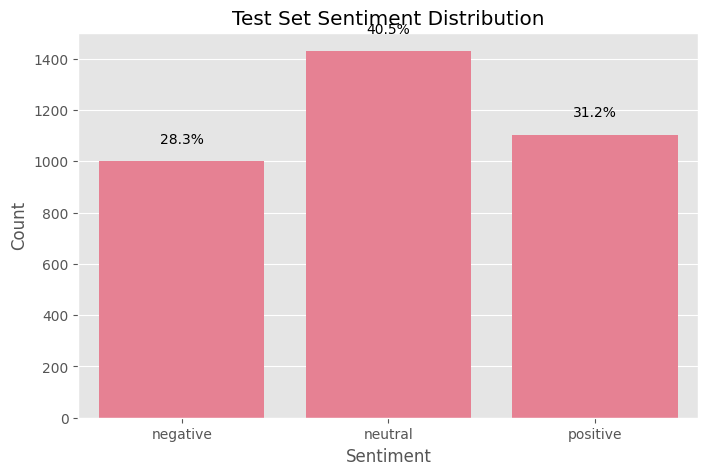

In [18]:
def plot_sentiment_distribution(df, title):
    """
    Plot the distribution of sentiment labels in a DataFrame using a count plot.

    Args:
        df : DataFrame containing a 'sentiment' column with values like 'negative', 'neutral', and 'positive'.
        title : Title for the plot.

    Displays:
        A bar plot showing the count and percentage of each sentiment class.
    """
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x='sentiment', data=df, order=['negative', 'neutral', 'positive'])
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + 0.02*total
        ax.annotate(percentage, (x, y), ha='center')

    plt.show()

# Plot for training, validation, and test sets
plot_sentiment_distribution(train_df, "Training Set Sentiment Distribution")
plot_sentiment_distribution(val_df, "Validation Set Sentiment Distribution")
plot_sentiment_distribution(test_df, "Test Set Sentiment Distribution")

### Text Length Analysis

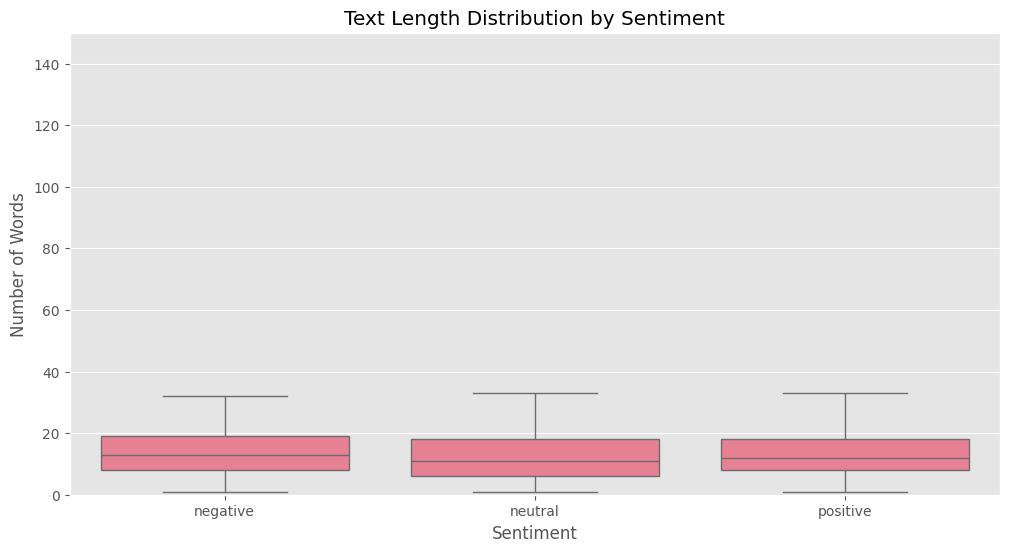

In [19]:
# Add text length columns
train_df['text_length'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='text_length', data=train_df,
            order=['negative', 'neutral', 'positive'])
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.ylim(0, 150)
plt.show()

In [20]:
# # Print statistics
# print("\nText length statistics (words):")
# print(train_df.groupby('sentiment')['text_length'].describe())



Text length statistics (words):
            count       mean       std  min  25%   50%   75%   max
sentiment                                                         
negative   7033.0  13.456420  6.874928  1.0  8.0  13.0  19.0  32.0
neutral    9976.0  12.312049  7.034976  1.0  6.0  11.0  18.0  33.0
positive   7723.0  13.106824  6.738184  1.0  8.0  12.0  18.0  33.0


### Word Frequency Analysis

In [21]:
def plot_word_cloud(text, title):
    """
    Generate and display a word cloud from a given text.

    Args:
        text : Input text to generate the word cloud.
        title : Title to display above the word cloud.

    Displays:
        A word cloud visualization of the most frequent words in the input text.
    """
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

### Word cloud for `positive` sentiment

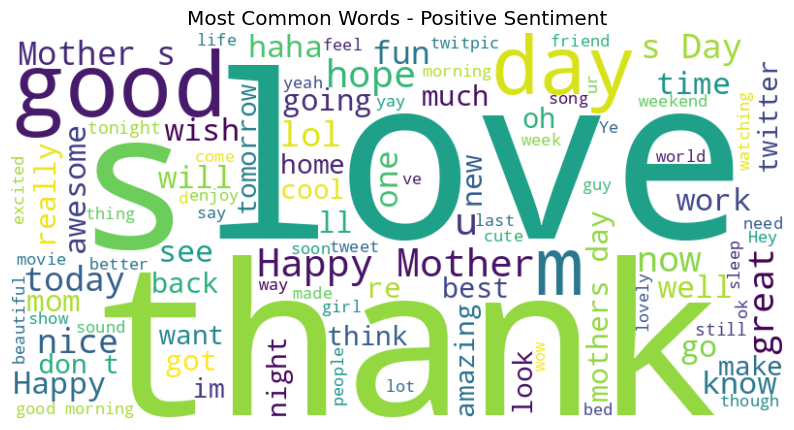

In [22]:
text = ' '.join(train_df[train_df['sentiment'] == 'positive']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words - Positive Sentiment')

### Word cloud for `negative` sentiment

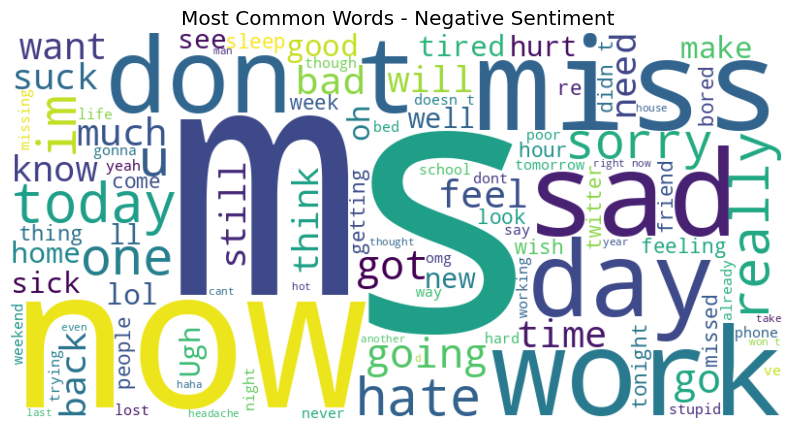

In [23]:
text = ' '.join(train_df[train_df['sentiment'] == 'negative']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words - Negative Sentiment')

### Word cloud for `neutral` sentiment

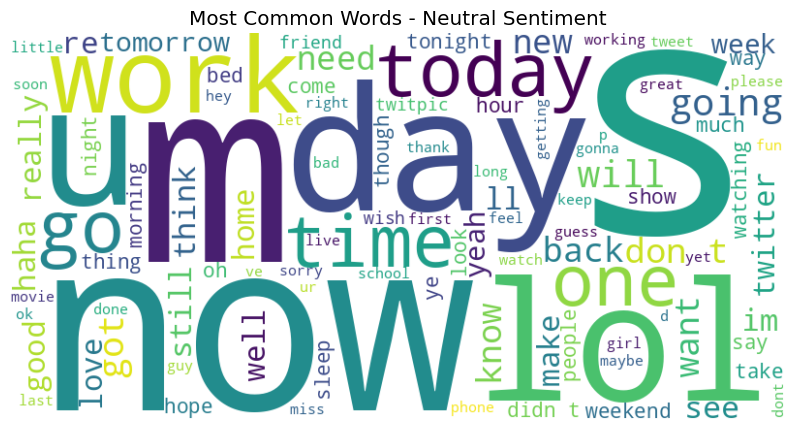

In [24]:
text = ' '.join(train_df[train_df['sentiment'] == 'neutral']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words - Neutral Sentiment')

### Top 10 Words by Sentiment

In [25]:
print("\n=== Top 10 Words by Sentiment ===")

def get_top_words(text_series, n=10):
    all_words = []
    for text in text_series:
        all_words.extend(text.lower().split())
    return Counter(all_words).most_common(n)

for sentiment in ['positive', 'neutral', 'negative']:
    top_words = get_top_words(train_df[train_df['sentiment'] == sentiment]['text'])
    print(f"\n{sentiment.capitalize()} sentiment:")
    for word, count in top_words:
        print(f"{word}: {count}")


=== Top 10 Words by Sentiment ===

Positive sentiment:
i: 3299
to: 2657
the: 2631
a: 2126
you: 1573
and: 1453
my: 1351
for: 1182
is: 998
it: 952

Neutral sentiment:
i: 4324
to: 3709
the: 3171
a: 2270
my: 1772
and: 1623
you: 1425
in: 1392
is: 1306
for: 1299

Negative sentiment:
i: 4061
to: 2603
the: 2199
my: 1840
a: 1626
and: 1396
is: 1187
in: 985
it: 925
so: 858


# Custom Dataset Class for Sentiment Analysis

The following code snippet defines a custom PyTorch dataset class `SentimentDataset` for loading and processing text data for sentiment analysis. It uses the BERT tokenizer to prepare text data for model training or evaluation.

- **`__init__(self, texts, labels, tokenizer, max_len)`**:
   - Initializes the dataset with texts, labels, a tokenizer, and a maximum sequence length.
   
- **`__len__(self)`**:
   - Returns the total number of samples in the dataset.
   
- **`__getitem__(self, idx)`**:
   - Retrieves the text and its corresponding label.
   - Tokenizes the text, adding special tokens, padding, and truncation to ensure uniform input lengths.
   - Returns the tokenized input along with the attention mask and label as tensors.


In [25]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT Tokenizer and Model

This code snippet loads a pre-trained BERT model for sentiment classification and moves it to a GPU if available.

- **`MODEL_NAME = 'bert-base-uncased'`**:
   - Defines the model name (`bert-base-uncased`), which is a version of BERT that uses lowercased text for tokenization.

- **`tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)`**:
   - Loads the pre-trained BERT tokenizer, which is used to convert text into tokens that BERT can process.

- **`model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, output_attentions=False, output_hidden_states=False)`**:
   - Loads the pre-trained BERT model for sequence classification.
   - Sets the number of labels to 3 (for positive, neutral, and negative sentiment).
   - Disables the output of attention weights and hidden states, as they are not needed for this task.

- **`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`**:
   - Checks if a GPU is available. If yes, the model will run on the GPU (`cuda`); otherwise, it will run on the CPU.

In [26]:
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  # positive, neutral, negative
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [27]:
MAX_LEN = 128
BATCH_SIZE = 16

# Preparing DataLoaders for Sentiment Analysis

This code prepares datasets and DataLoaders for training, validation, and testing.

- **Create Datasets**:
   - Initializes `SentimentDataset` for training, validation, and testing with text, labels, tokenizer, and `MAX_LEN`.

- **Create DataLoaders**:
   - **`train_loader`**: Loads training data with shuffling.
   - **`val_loader`**: Loads validation data without shuffling.
   - **`test_loader`**: Loads test data without shuffling.

DataLoaders handle batching and shuffling for efficient processing during model training and evaluation.


In [28]:
train_dataset = SentimentDataset(
    train_df.text.values,
    train_df.label.values,
    tokenizer,
    MAX_LEN
)

val_dataset = SentimentDataset(
    val_df.text.values,
    val_df.label.values,
    tokenizer,
    MAX_LEN
)

test_dataset = SentimentDataset(
    test_df.text.values,
    test_df.label.values,
    tokenizer,
    MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Model Training Setup

- **Hyperparameters**:
   - `EPOCHS = 10`: Number of training epochs.
   - `LEARNING_RATE = 2e-5`: Learning rate for the optimizer.
   - `EARLY_STOPPING_PATIENCE = 2`: Number of epochs to wait before stopping if no improvement.
   - `MIN_DELTA = 0.001`: Minimum change to consider as progress.

- **Optimizer**:
   - `AdamW`: Optimizer used with model parameters and specified learning rate.

- **Scheduler**:
   - `get_linear_schedule_with_warmup`: Learning rate scheduler for gradual warmup and decay.

- **Loss Function**:
   - `CrossEntropyLoss`: Loss function for multi-class classification, moved to the specified device (`GPU` or `CPU`).


In [29]:
EPOCHS = 10
LEARNING_RATE = 2e-5
EARLY_STOPPING_PATIENCE = 2  # Number of epochs to wait before stopping
MIN_DELTA = 0.001  # Minimum improvement to consider as progress

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

# Model Training and Evaluation Functions

- **`train_epoch` Function**:
   - Trains the model for one epoch.
   - **Input**: Model, data loader, loss function, optimizer, device, scheduler.
   - **Process**:
     - For each batch, moves data to device, computes loss, and makes predictions.
     - Performs backpropagation and updates the model using optimizer and scheduler.
     - Clips gradients to avoid explosion.
   - **Output**: Training accuracy and average loss.

- **`eval_model` Function**:
   - Evaluates the model on the validation/test dataset.
   - **Input**: Model, data loader, loss function, device.
   - **Process**:
     - Computes loss and predictions without updating the model parameters.
   - **Output**: Evaluation accuracy and average loss.


In [30]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Training with Early Stopping

- **Initialization**:
   - `best_accuracy`: Tracks the best validation accuracy.
   - `patience_counter`: Counts epochs without improvement.
   - `early_stop`: Flag to trigger early stopping.

- **Training Loop**:
   - For each epoch:
     - Trains the model and evaluates on the validation set.
     - Tracks training loss and accuracy, and validation loss and accuracy.

- **Early Stopping**:
   - If validation accuracy improves, saves the model and resets `patience_counter`.
   - If no improvement for `EARLY_STOPPING_PATIENCE` epochs, triggers early stopping.

- **Final Model**:
   - Loads the best model state before early stopping.
   - Prints the best validation accuracy.


In [31]:
best_accuracy = 0
patience_counter = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print("Early stopping triggered!")
        break

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )

    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device
    )

    print(f'Validation loss {val_loss:.4f} accuracy {val_acc:.4f}')

    # Early stopping logic
    if val_acc > best_accuracy + MIN_DELTA:
        best_accuracy = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')
        print(f"Validation accuracy improved to {val_acc:.4f}, saving model...")
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy ({patience_counter}/{EARLY_STOPPING_PATIENCE})")
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            early_stop = True

    print()

# Load the best model before early stopping
model.load_state_dict(torch.load('best_model_state.bin'))
print(f"Training complete! Best validation accuracy: {best_accuracy:.4f}")

Epoch 1/10
----------


Training: 100%|██████████| 1546/1546 [09:08<00:00,  2.82it/s]


Train loss 0.5817 accuracy 0.7623


Evaluation: 100%|██████████| 172/172 [00:20<00:00,  8.21it/s]


Validation loss 0.5031 accuracy 0.8049
Validation accuracy improved to 0.8049, saving model...

Epoch 2/10
----------


Training: 100%|██████████| 1546/1546 [09:09<00:00,  2.81it/s]


Train loss 0.4065 accuracy 0.8446


Evaluation: 100%|██████████| 172/172 [00:20<00:00,  8.19it/s]


Validation loss 0.5227 accuracy 0.8031
No improvement in validation accuracy (1/2)

Epoch 3/10
----------


Training: 100%|██████████| 1546/1546 [09:08<00:00,  2.82it/s]


Train loss 0.2713 accuracy 0.9061


Evaluation: 100%|██████████| 172/172 [00:21<00:00,  8.14it/s]


Validation loss 0.6671 accuracy 0.7908
No improvement in validation accuracy (2/2)

Early stopping triggered!
Training complete! Best validation accuracy: 0.8049


 Early stopping was triggered at epoch = 3 with a validation accuracy of 0.8049

# Model Evaluation and Prediction

1. **Load Best Model**:
   - Loads the saved best model state using `torch.load()` and moves it to the selected device.

2. **`get_predictions` Function**:
   - Evaluates the model on the test set.
   - Collects predictions and real values.
   
3. **Output**:
   - Returns predictions (`y_pred`) and real values (`y_test`) as tensors.


In [32]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, real_values

y_pred, y_test = get_predictions(model, test_loader)

# Classification Report

In [33]:
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['negative', 'neutral', 'positive']
))


Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.82      0.80      1001
     neutral       0.76      0.77      0.76      1430
    positive       0.87      0.80      0.83      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.80      0.80      3534
weighted avg       0.80      0.79      0.79      3534



# Sentiment Prediction Function

In [34]:
def predict_sentiment(text):
    """
    Predicts the sentiment of a given text.

    Args:
        text : The input text for sentiment analysis.

    Returns:
        str: The predicted sentiment label ('negative', 'neutral', 'positive').
    """
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, pred = torch.max(outputs.logits, dim=1)

    sentiment_labels = ['negative', 'neutral', 'positive']
    return sentiment_labels[pred]

# Example for neutral sentiment
sample_text = "The product was i don't know."
print(f"\nSample text: '{sample_text}'")
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

# Example for positive sentiment
sample_text = "The product was superb.."
print(f"\nSample text: '{sample_text}'")
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")

# Example for negative sentiment
sample_text = "The product was disappointing."
print(f"\nSample text: '{sample_text}'")
print(f"Predicted sentiment: {predict_sentiment(sample_text)}")


Sample text: 'The product was i don't know.'
Predicted sentiment: neutral

Sample text: 'The product was superb..'
Predicted sentiment: positive

Sample text: 'The product was disappointing.'
Predicted sentiment: negative


# Sentiment Analysis Report

This function compares the model's predictions with actual labels in the test set and displays a styled table showing:

- Input text
- True sentiment
- Predicted sentiment
- Whether the prediction matches the true label

It also calculates and prints the final accuracy.


In [35]:
def generate_sentiment_report(model, tokenizer, test_df, device, max_len=128):
    """
    Generates a sentiment analysis report comparing predictions with actual labels

    Args:
        model: Fine-tuned BERT model
        tokenizer: BERT tokenizer
        test_df: DataFrame containing 'text' and 'label' columns
        device: torch device ('cuda' or 'cpu')
        max_len: Maximum sequence length

    Returns:
        DataFrame with results and prints accuracy
    """
    # Create a copy of the test dataframe to store results
    report_df = test_df.copy()
    report_df['predicted_label'] = -1
    report_df['predicted_sentiment'] = ""
    report_df['match'] = ""

    # Sentiment mapping
    label_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

    # Get predictions for each text
    for i, row in report_df.iterrows():
        text = str(row['text'])
        true_label = row['label']

        # Tokenize and prepare input
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # Get prediction
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

        _, pred = torch.max(outputs.logits, dim=1)
        predicted_label = pred.item()
        predicted_sentiment = label_to_sentiment[predicted_label]

        # Store results
        report_df.at[i, 'predicted_label'] = predicted_label
        report_df.at[i, 'predicted_sentiment'] = predicted_sentiment
        report_df.at[i, 'match'] = '✓' if predicted_label == true_label else '✗'

    # Calculate accuracy
    accuracy = (report_df['match'] == '✓').mean()

    # Create report
    styled_report = report_df[['text', 'sentiment', 'predicted_sentiment', 'match']].style \
        .set_caption(f"Sentiment Analysis Report (Accuracy: {accuracy:.2%})") \
        .set_properties(**{'text-align': 'left'}) \
        .set_table_styles([{
            'selector': 'th',
            'props': [('text-align', 'left')]
        }])


    display(styled_report)

    # Print accuracy
    print(f"\nFinal Accuracy on Test Set: {accuracy:.2%}")

    return report_df



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# display the report
sentiment_report = generate_sentiment_report(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df,
    device=device,
    max_len=128
)


Final Accuracy on Test Set: 79.32%


# Conclusion

Based on the classification report, the model performs reasonably well on the sentiment analysis task:

- **Accuracy**: The model achieves an overall accuracy of **79%**.
- **Precision**: The highest precision is observed for the **positive** class (0.87), showing good ability to avoid false positives for positive sentiments.
- **Recall**: The **negative** class has the highest recall (0.82), meaning the model is effective in correctly identifying negative sentiments.
- **F1-Score**: The **positive** class also has the highest F1-score (0.83), balancing precision and recall well.

In short, the model works well across all three sentiment categories, with slightly better performance for positive and negative sentiments. There's still some room to improve, especially for the neutral class, but overall, the model performs good on the dataset.